# Loading Image Files Using Sources

<a href="https://colab.research.google.com/github/DeepTrackAI/DeepTrack2/blob/develop/tutorials/1-getting-started/DTGS111_datafiles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install deeptrack  # Uncomment if running on Colab/Kaggle.

This tutorial gives an overview of how to load external data files into DeepTrack2. You will use a malaria classification dataset as an example.

In [2]:
import deeptrack as dt
import matplotlib.pyplot as plt

## 1. Downloading the Dataset

For convenience, you will download the data using torchvision. The dataset is available at [https://lhncbc.nlm.nih.gov/publication/pub9932.](https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip)


In [3]:
import os

from torchvision.datasets.utils import download_url, _extract_zip

dataset_path = os.path.join(".", "blood_smears_dataset")
if not os.path.exists(dataset_path):
    url = "https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip"
    download_url(url, ".")
    _extract_zip("cell_images.zip", dataset_path, None)
    os.remove("cell_images.zip")

## 2. Discovering the Dataset

Next, you will discover the dataset using DeepTrack2 `Source`. `Source` complements `Feature` by providing metadata about the data to be processed. Here, you will create a `Source` object containing all the files in the dataset.

In [4]:
files = dt.sources.ImageFolder(root=os.path.join(dataset_path, "cell_images"))

print(f"Dataset contains {len(files)} images")

Dataset contains 27558 images


The `ImageFolder` object contains a collection of files, with the total number given by `len(files)`. Each file is a dictionary with three keys that can be accessed using `Feature`s:

- `path` (the path to the file)

- `label` (the class of the image)

- `label_name` (the name of the class).

You can inspect the first item of the dataset to see what these look like.

In [5]:
print(f"There are {len(files)} files.")
print(f"The first file is {files[0]}.")

There are 27558 files.
The first file is SourceItem({'path': './blood_smears_dataset/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png', 'label': 1, 'label_name': 'Parasitized'}).


### 2.1. Combining sources with features

`Sources` can be provided as arguments when creating an object of the `Feature` class. Once created, you can resolve (`.call()`) the feature with an item of the `Source` to get the value of the feature for that item. First, let us demonstrate this for loading some images.

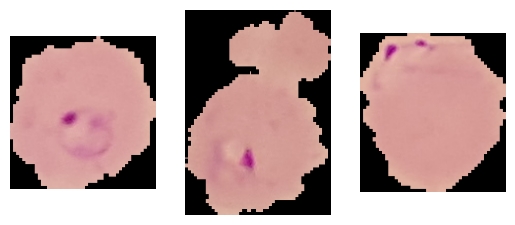

In [6]:
loader = dt.LoadImage(path=files.path)

fig, ax = plt.subplots(1, 3)

for ax, file in zip(ax.flatten(), files):
    image = loader(file)
    ax.imshow(image)
    ax.axis("off")

Next, you can extract the label, which will be the target of the classification task.

In [7]:
label_pipeline = dt.Value(value=files.label)

Let us combine these to create a data pipeline for image classification:

In [8]:
loader_pipeline = (
    loader 
    >> dt.Resize((32, 32))
    >> dt.Divide(255)
)

data_pipeline = loader_pipeline & label_pipeline

You can now plot some images together with their label.

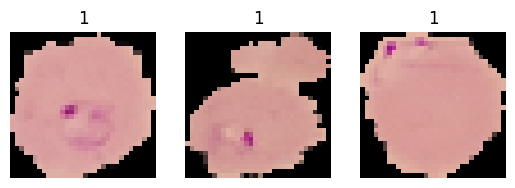

In [9]:
fig, ax = plt.subplots(1, 3)

for ax, file in zip(ax.flatten(), files):
    image, label = data_pipeline.update()(file)
    ax.imshow(image)
    ax.set_title(label)
    ax.axis("off")

# 3. Creating a PyTorch Dataset

To work with the data, you will need to create a PyTorch `Dataset` object. This will allow you to easily access the data and use it to train a model.

Note that the image is in the PyTorch format (channels, height, width). `Dataset` will automatically make NumPy arrays into channel-first format.

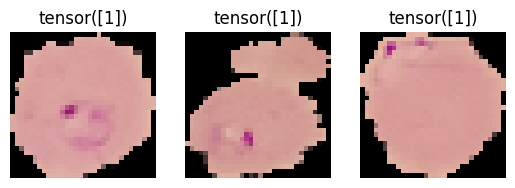

In [10]:
dataset = dt.pytorch.Dataset(data_pipeline, files)

fig, ax = plt.subplots(1, 3)

for ax, (image, label) in zip(ax.flatten(), dataset):
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title(label)
    ax.axis("off")

### 3.1. Splitting Training and Validation Sets

This dataset is a subclass of PyTorch's `Dataset` class, which allows you to easily split the data into training and validation sets. You can then use these sets to train and validate a model.

In [11]:
import torch

train, test = torch.utils.data.random_split(dataset, [0.8, 0.2])

## 4. Training

With the dataset ready, you can now train a neural network model. You will use a simple convolutional neural network with two convolutional layers and two fully connected layers. You will use the Adam optimizer and the cross-entropy loss function.

In [12]:
import deeptrack.deeplay as dl

model = dl.Sequential(
    # Convolutional encoder.
    dl.ConvolutionalEncoder2d(3, [32], 64),
    # Global average pooling ((w, h) -> (1, 1)).
    torch.nn.AdaptiveMaxPool2d((1, 1)),
    # Fully connected layer.
    dl.MultiLayerPerceptron(64, [32], 1, out_activation=torch.nn.Sigmoid())
)

# BinaryClassifier application sets a good loss and adds accuracy metric.
model = dl.BinaryClassifier(model)

print(model)

BinaryClassifier(
  (loss): BCELoss()
  (train_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=test
  )
  (model): Sequential(
    (0): ConvolutionalEncoder2d(
      (blocks): LayerList(
        (0): Conv2dBlock(
          (layer): Layer[Conv2d](in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
          (activation): Layer[ReLU]()
        )
        (1): Conv2dBlock(
          (pool): Layer[MaxPool2d](kernel_size=2, stride=2)
          (layer): Layer[Conv2d](in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
          (activation): Layer[Identity]()
        )
      )
      (postprocess): Layer[Identity]()
    )
    (1): AdaptiveMaxPool2d(output_size=(1, 1))
    (2): MultiLayerPerceptron(
      (blocks): LayerList(
        (0): Linea

You can now train your model.

In [13]:
h = model.fit(train, val_data=test, max_epochs=10)

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ BCELoss          │      0 │ train │
│ 1 │ train_metrics │ MetricCollection │      0 │ train │
│ 2 │ val_metrics   │ MetricCollection │      0 │ train │
│ 3 │ test_metrics  │ MetricCollection │      0 │ train │
│ 4 │ model         │ Sequential       │ 21.5 K │ train │
│ 5 │ optimizer     │ Adam             │      0 │ train │
└───┴───────────────┴──────────────────┴────────┴───────┘

Trainable params: 21.5 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 21.5 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 28                                                                                          
Modules in eval mode: 0

Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/py
torch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a 
bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to
improve performance.

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/py
torch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a 
bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to
improve performance.

You can plot the training history.

(0.9, 1.0)

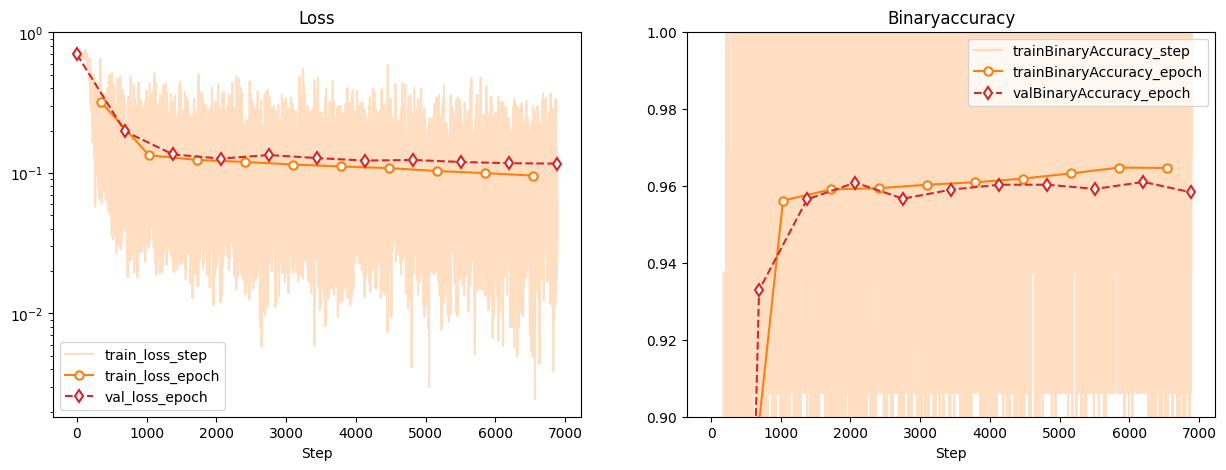

In [14]:
fig, axes = h.plot()
axes[1].set_yscale("linear")
axes[1].set_ylim(0.9, 1.0)

Finally, you can use `torchmetrics` to easily calculate extra metrics such as F1 score.

In [15]:
import torchmetrics as tm

f1 = tm.F1Score(task="binary")
confusion_matrix = tm.ConfusionMatrix(task="binary")
ROC = tm.ROC(task="binary")

results = model.test(
    test, 
    metrics={"f1": f1, "confusion_matrix": confusion_matrix, "roc": ROC},
)

print(f"Test f1 score: {results['f1'] * 100:.2f}%")

100%|██████████| 173/173 [00:01<00:00, 126.08it/s]

Test f1 score: 95.80%


Plot out the confusion matrix and the ROC curve to see how well the model is performing.

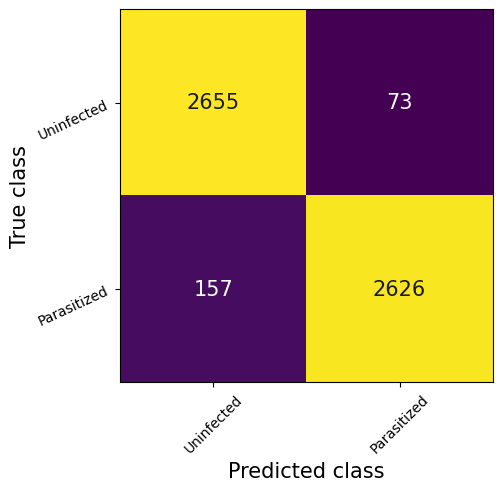

In [16]:
confusion_matrix.plot(labels=["Uninfected", "Parasitized"]);

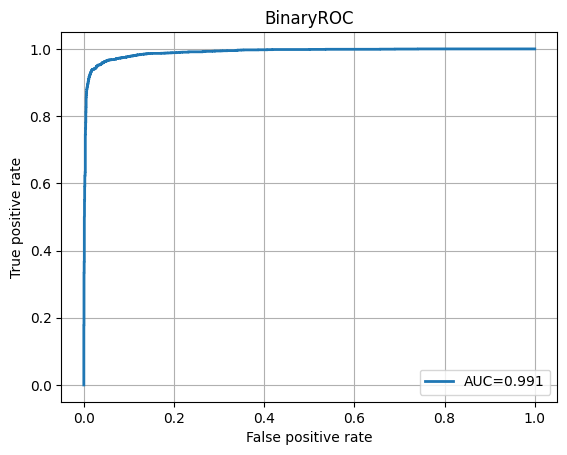

In [17]:
ROC.plot(score=True);